In [54]:
%load_ext autoreload
%autoreload 2

from git_analysis import GitProcessor, convert_to_item_basket_onehot, HierarchyType
import networkx as nx
import pandas as pd
import pyvis
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import logging

logging.basicConfig()
logging.getLogger("git_processor").setLevel(logging.INFO)
logging.getLogger("java_change_detector").setLevel(logging.ERROR)
logging.getLogger("assoc_mining").setLevel(logging.INFO)

GIT_URL = "https://github.com/skylot/jadx"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with GitProcessor(GIT_URL) as git:
    prs = git.get_processed_prs()
    commits, _ = git.get_processed_commits()

    pr_method_df = convert_to_item_basket_onehot(prs, HierarchyType.method, "pr")
    pr_class_df = convert_to_item_basket_onehot(prs, HierarchyType.type_def, "pr")
    pr_package_df = convert_to_item_basket_onehot(prs, HierarchyType.package, "pr")

    commit_method_df = convert_to_item_basket_onehot(commits, HierarchyType.method, "commit")
    commit_class_df = convert_to_item_basket_onehot(commits, HierarchyType.type_def, "commit")
    commit_package_df = convert_to_item_basket_onehot(commits, HierarchyType.package, "commit")


    dfs = {
        ("commit", HierarchyType.method): { "onehot": commit_method_df },
        ("commit", HierarchyType.type_def): { "onehot": commit_class_df },
        ("commit", HierarchyType.package): { "onehot": commit_package_df },
        ("pr", HierarchyType.method): { "onehot": pr_method_df },
        ("pr", HierarchyType.type_def): { "onehot": pr_class_df },
        ("pr", HierarchyType.package): { "onehot": pr_package_df }
    }

INFO:git_processor:Using pre-existing git repository at C:\dev\gitAnalysis\GIT_REPOS\jadx
INFO:git_processor:Using pre-existing cache at C:\dev\gitAnalysis\GIT_REPOS_SHELVE\jadx
INFO:git_processor:Processing git repository located at C:\dev\gitAnalysis\GIT_REPOS\jadx
INFO:assoc_mining:item type: method, basket type: pr, #baskets: 248, #items: 4343
INFO:assoc_mining:item type: type_def, basket type: pr, #baskets: 254, #items: 1072
INFO:assoc_mining:item type: package, basket type: pr, #baskets: 254, #items: 106
INFO:assoc_mining:item type: method, basket type: commit, #baskets: 1423, #items: 13359
INFO:assoc_mining:item type: type_def, basket type: commit, #baskets: 1452, #items: 2888
INFO:assoc_mining:item type: package, basket type: commit, #baskets: 1455, #items: 192


In [36]:
# These define the models we'll use. "min" is min_support * numBaskets, 
# if one of the algorithms is too slow, 
dfs = {
    ("commit", HierarchyType.method): {"onehot": commit_method_df, "min": 5},
    ("commit", HierarchyType.type_def): {"onehot": commit_class_df, "min": 5},
    ("commit", HierarchyType.package): {"onehot": commit_package_df, "min": 5},
    ("pr", HierarchyType.method): {"onehot": pr_method_df, "min": 1},
    ("pr", HierarchyType.type_def): {"onehot": pr_class_df, "min": 1},
    ("pr", HierarchyType.package): {"onehot": pr_package_df, "min": 1}
}


In [40]:
def get_freq_itemsets_and_rules(item_basket_df, min_support, min_threshold=0):
      # item_basket_df = commit_method_df
      # min_support = 10/len(item_basket_df)
      # min_threshold = 0
      print(f"Number of baskets: {len(item_basket_df)}, number of items: {len(item_basket_df.columns)}")
      print(f"Using a min support of {min_support:.4f}, meaning that an item needs to appear in at least "
            f"{min_support * len(item_basket_df)} out of {len(item_basket_df)} baskets.")
      freq_itemsets = apriori(item_basket_df, min_support=min_support, use_colnames=True, max_len=2)
      print(f"Got {len(freq_itemsets)} frequent itemsets")
      rules = association_rules(freq_itemsets, metric='confidence', min_threshold=min_threshold)
      rules["weight"] = 1 - rules["confidence"]
      rules["antecedents"] = rules["antecedents"].apply(lambda s: next(iter(s)))
      rules["consequents"] = rules["consequents"].apply(lambda s: next(iter(s)))
      print(f"Got {len(rules)} rules")

      return freq_itemsets, rules

for key, val in dfs.items():
      print(key)
      df, min_items =  val["onehot"], val["min"]
      freq_itemsets, rules = get_freq_itemsets_and_rules(df, min_support=min_items/len(df))
      val["freq_itemsets"] = freq_itemsets
      val["rules"] = rules

('commit', <HierarchyType.method: 3>)
Number of baskets: 1423, number of items: 13359
Using a min support of 0.0035, meaning that an item needs to appear in at least 5.0 out of 1423 baskets.
Got 352961 frequent itemsets
Got 701832 rules
('commit', <HierarchyType.type_def: 2>)
Number of baskets: 1452, number of items: 2888
Using a min support of 0.0034, meaning that an item needs to appear in at least 5.0 out of 1452 baskets.
Got 41656 frequent itemsets
Got 81846 rules
('commit', <HierarchyType.package: 1>)
Number of baskets: 1455, number of items: 192
Using a min support of 0.0034, meaning that an item needs to appear in at least 5.0 out of 1455 baskets.
Got 2863 frequent itemsets
Got 5466 rules
('pr', <HierarchyType.method: 3>)
Number of baskets: 248, number of items: 4343
Using a min support of 0.0040, meaning that an item needs to appear in at least 1.0 out of 248 baskets.
Got 1032071 frequent itemsets
Got 2055456 rules
('pr', <HierarchyType.type_def: 2>)
Number of baskets: 254, num

In [60]:
def get_dfs(refresh=False):
    with GitProcessor(GIT_URL) as git:
        if "dfs" not in git.shelve or refresh:
            print("Calculating item-basket DFs and assoc rules from scratch")
            # These define the models we'll use. "min" is min_support * numBaskets, 
            # if one of the algorithms is too slow, 
            dfs = {
                ("commit", HierarchyType.method): {"onehot": commit_method_df, "min": 5},
                ("commit", HierarchyType.type_def): {"onehot": commit_class_df, "min": 5},
                ("commit", HierarchyType.package): {"onehot": commit_package_df, "min": 5},
                ("pr", HierarchyType.method): {"onehot": pr_method_df, "min": 1},
                ("pr", HierarchyType.type_def): {"onehot": pr_class_df, "min": 1},
                ("pr", HierarchyType.package): {"onehot": pr_package_df, "min": 1}
            }
            for key, val in dfs.items():
                print(key)
                df, min_items =  val["onehot"], val["min"]
                freq_itemsets, rules = get_freq_itemsets_and_rules(df, min_support=min_items/len(df))
                val["freq_itemsets"] = freq_itemsets
                val["rules"] = rules
            git.shelve["dfs"] = dfs
            print("Done, saved results to cache")
        else:
            print("Obtaining item-basket DFs and assoc rules from cache")
            dfs = git.shelve["dfs"]
    return dfs

# change to True if you changed anything in the 'dfs' dictionary and want to re-run
dfs = get_dfs(refresh=False)

INFO:git_processor:Using pre-existing git repository at C:\dev\gitAnalysis\GIT_REPOS\jadx
INFO:git_processor:Using pre-existing cache at C:\dev\gitAnalysis\GIT_REPOS_SHELVE\jadx
INFO:git_processor:Processing git repository located at C:\dev\gitAnalysis\GIT_REPOS\jadx


Calculating item-basket DFs and assoc rules from scratch
('commit', <HierarchyType.method: 3>)
Number of baskets: 1423, number of items: 13359
Using a min support of 0.0035, meaning that an item needs to appear in at least 5.0 out of 1423 baskets.
Got 352961 frequent itemsets
Got 701832 rules
('commit', <HierarchyType.type_def: 2>)
Number of baskets: 1452, number of items: 2888
Using a min support of 0.0034, meaning that an item needs to appear in at least 5.0 out of 1452 baskets.
Got 41656 frequent itemsets
Got 81846 rules
('commit', <HierarchyType.package: 1>)
Number of baskets: 1455, number of items: 192
Using a min support of 0.0034, meaning that an item needs to appear in at least 5.0 out of 1455 baskets.
Got 2863 frequent itemsets
Got 5466 rules
('pr', <HierarchyType.method: 3>)
Number of baskets: 248, number of items: 4343
Using a min support of 0.0040, meaning that an item needs to appear in at least 1.0 out of 248 baskets.
Got 1032071 frequent itemsets


In [58]:
recs = []
for key, val in dfs.items():
    commit_or_pr, hierch_type = key
    onehot = val["onehot"]
    recs.append({
        "basket_type": commit_or_pr,
        "item_type": hierch_type.name,
        "#baskets": len(onehot),
        "#items": len(onehot.columns),
    })
stat_df = pd.DataFrame.from_records(recs)
stat_df.set_index(["basket_type", "item_type"])

#baskets  #items
basket_type item_type                  
commit      method         1423   13359
            type_def       1452    2888
            package        1455     192
pr          method          248    4343
            type_def        254    1072
            package         254     106

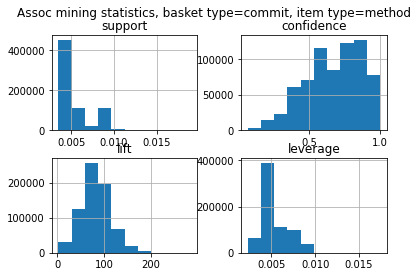

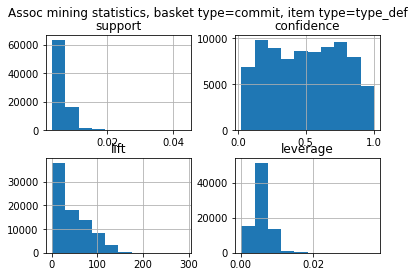

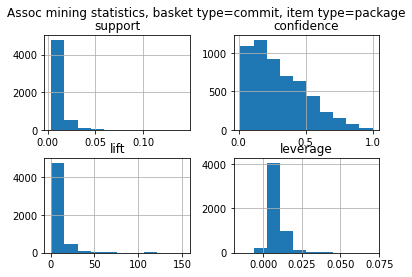

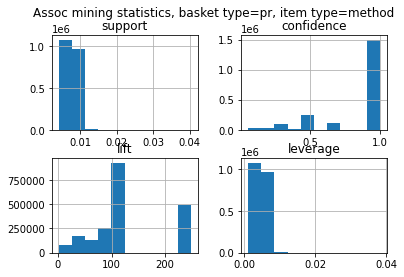

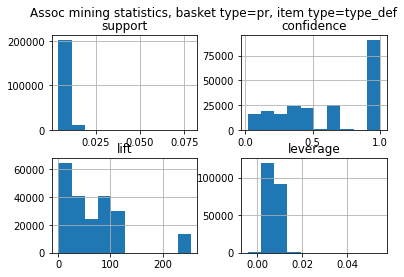

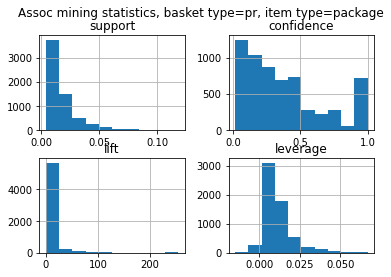

In [48]:
for key, v in dfs.items():
    rules_df: pd.DataFrame = v["rules"]
    axes = rules_df.hist(column=["support", "confidence", "lift", "leverage"])

    commit_or_pr, hierch_type = key
    plt.suptitle(f"Assoc mining statistics, basket type={commit_or_pr}, item type={hierch_type.name}")
    plt.show()


In [24]:
filtered_rules = rules[rules["confidence"] > 0.9]

graph = nx.convert_matrix.from_pandas_edgelist(filtered_rules, source="consequents", target="antecedents", edge_attr="weight")
print(f"Graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges")
network = pyvis.network.Network(height='500px', width='500px', directed=True, notebook=True)
network.from_nx(graph)
#network.show("nx.html")
network


Graph has 537 nodes and 46900 edges


<class 'pyvis.network.Network'> |N|=537 |E|=46,900